In [ ]:
""" Step5_2_dcgan.ipynb
 Group: Sieze the Data
Course: DSCI 550 - Spring 2022
Date: April 2022

Description:
This program extracts from .jpg images located in the PATH: dcgan_images/dcgan_input and outputs fake image results into PATH: dcgan_images/dcgan_output

The program replaced any pooling layers from each .jpg file located in the dcgan_input folder with strided convolutions (discriminator) and fractional-strided convolutions(generator) using batch norm in both the generator and the discriminator.

Note: This program can take between 3-4 hours from execution to completion.

"""

In [ ]:
import os
import time
import tensorflow as tf
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def generator(z, output_channel_dim, training):
    with tf.variable_scope("generator", reuse= not training):
        
        # 8x8x1024
        fully_connected = tf.layers.dense(z, 8*8*1024)
        fully_connected = tf.reshape(fully_connected, (-1, 8, 8, 1024))
        fully_connected = tf.nn.leaky_relu(fully_connected)

        # 8x8x1024 -> 16x16x512
        trans_conv1 = tf.layers.conv2d_transpose(inputs=fully_connected,
                                                 filters=512,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv1")
        batch_trans_conv1 = tf.layers.batch_normalization(inputs = trans_conv1,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv1")
        trans_conv1_out = tf.nn.leaky_relu(batch_trans_conv1,
                                           name="trans_conv1_out")
        
        # 16x16x512 -> 32x32x256
        trans_conv2 = tf.layers.conv2d_transpose(inputs=trans_conv1_out,
                                                 filters=256,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv2")
        batch_trans_conv2 = tf.layers.batch_normalization(inputs = trans_conv2,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv2")
        trans_conv2_out = tf.nn.leaky_relu(batch_trans_conv2,
                                           name="trans_conv2_out")
        
        # 32x32x256 -> 64x64x128
        trans_conv3 = tf.layers.conv2d_transpose(inputs=trans_conv2_out,
                                                 filters=128,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv3")
        batch_trans_conv3 = tf.layers.batch_normalization(inputs = trans_conv3,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv3")
        trans_conv3_out = tf.nn.leaky_relu(batch_trans_conv3,
                                           name="trans_conv3_out")
        
        # 64x64x128 -> 128x128x64
        trans_conv4 = tf.layers.conv2d_transpose(inputs=trans_conv3_out,
                                                 filters=64,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv4")
        batch_trans_conv4 = tf.layers.batch_normalization(inputs = trans_conv4,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv4")
        trans_conv4_out = tf.nn.leaky_relu(batch_trans_conv4,
                                           name="trans_conv4_out")
        
        # 128x128x64 -> 128x128x3
        logits = tf.layers.conv2d_transpose(inputs=trans_conv4_out,
                                            filters=3,
                                            kernel_size=[5,5],
                                            strides=[1,1],
                                            padding="SAME",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                            name="logits")
        out = tf.tanh(logits, name="out")
        return out

In [ ]:
def discriminator(x, reuse):
    with tf.variable_scope("discriminator", reuse=reuse): 
        
        # 128*128*3 -> 64x64x64 
        conv1 = tf.layers.conv2d(inputs=x,
                                 filters=64,
                                 kernel_size=[5,5],
                                 strides=[2,2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv1')
        batch_norm1 = tf.layers.batch_normalization(conv1,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm1')
        conv1_out = tf.nn.leaky_relu(batch_norm1,
                                     name="conv1_out")
        
        # 64x64x64-> 32x32x128 
        conv2 = tf.layers.conv2d(inputs=conv1_out,
                                 filters=128,
                                 kernel_size=[5, 5],
                                 strides=[2, 2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv2')
        batch_norm2 = tf.layers.batch_normalization(conv2,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm2')
        conv2_out = tf.nn.leaky_relu(batch_norm2,
                                     name="conv2_out")
        
        # 32x32x128 -> 16x16x256  
        conv3 = tf.layers.conv2d(inputs=conv2_out,
                                 filters=256,
                                 kernel_size=[5, 5],
                                 strides=[2, 2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv3')
        batch_norm3 = tf.layers.batch_normalization(conv3,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm3')
        conv3_out = tf.nn.leaky_relu(batch_norm3,
                                     name="conv3_out")
        
        # 16x16x256 -> 16x16x512
        conv4 = tf.layers.conv2d(inputs=conv3_out,
                                 filters=512,
                                 kernel_size=[5, 5],
                                 strides=[1, 1],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv4')
        batch_norm4 = tf.layers.batch_normalization(conv4,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm4')
        conv4_out = tf.nn.leaky_relu(batch_norm4,
                                     name="conv4_out")
        
        # 16x16x512 -> 8x8x1024
        conv5 = tf.layers.conv2d(inputs=conv4_out,
                                filters=1024,
                                kernel_size=[5, 5],
                                strides=[2, 2],
                                padding="SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                name='conv5')
        batch_norm5 = tf.layers.batch_normalization(conv5,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm5')
        conv5_out = tf.nn.leaky_relu(batch_norm5,
                                     name="conv5_out")

        flatten = tf.reshape(conv5_out, (-1, 8*8*1024))
        logits = tf.layers.dense(inputs=flatten,
                                 units=1,
                                 activation=None)
        out = tf.sigmoid(logits)
        return out, logits

In [ ]:
def model_loss(input_real, input_z, output_channel_dim):
    g_model = generator(input_z, output_channel_dim, True)

    noisy_input_real = input_real + tf.random_normal(shape=tf.shape(input_real),
                                                     mean=0.0,
                                                     stddev=random.uniform(0.0, 0.1),
                                                     dtype=tf.float32)
    
    d_model_real, d_logits_real = discriminator(noisy_input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*random.uniform(0.9, 1.0)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = tf.reduce_mean(0.5 * (d_loss_real + d_loss_fake))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss

In [ ]:

def model_optimizers(d_loss, g_loss):
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator') or op.name.startswith('discriminator')]
    
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=LR_D, beta1=BETA1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=LR_G, beta1=BETA1).minimize(g_loss, var_list=g_vars)  
    return d_train_opt, g_train_opt

In [ ]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate_G = tf.placeholder(tf.float32, name="lr_g")
    learning_rate_D = tf.placeholder(tf.float32, name="lr_d")
    return inputs_real, inputs_z, learning_rate_G, learning_rate_D

In [ ]:
def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMAGE_SIZE, IMAGE_SIZE))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
        image.save(name+"_"+str(epoch)+"_"+str(index)+".png") 
    plt.savefig(name+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [ ]:
def test(sess, input_z, out_channel_dim, epoch):
    example_z = np.random.uniform(-1, 1, size=[SAMPLES_TO_SHOW, input_z.get_shape().as_list()[-1]])
    samples = sess.run(generator(input_z, out_channel_dim, False), feed_dict={input_z: example_z})
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, OUTPUT_DIR + "samples", epoch)

In [ ]:
def summarize_epoch(epoch, sess, d_losses, g_losses, input_z, data_shape, saver):
    print("\nEpoch {}/{}".format(epoch, EPOCHS),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-MINIBATCH_SIZE:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-MINIBATCH_SIZE:])))
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    saver.save(sess, OUTPUT_DIR + "model_" + str(epoch) + ".ckpt")
    test(sess, input_z, data_shape[3], epoch)

In [ ]:
def get_batch(dataset):
    files = random.sample(dataset, BATCH_SIZE)
    batch = []
    for file in files:
        if random.choice([True, False]):
            batch.append(np.asarray(Image.open(file).transpose(Image.FLIP_LEFT_RIGHT)))
        else:
            batch.append(np.asarray(Image.open(file)))                     
    batch = np.asarray(batch)
    normalized_batch = (batch / 127.5) - 1.0
    return normalized_batch, files

In [ ]:
def train(data_shape, epoch, checkpoint_path):
    input_images, input_z, lr_G, lr_D = model_inputs(data_shape[1:], NOISE_SIZE)
    d_loss, g_loss = model_loss(input_images, input_z, data_shape[3])
    d_opt, g_opt = model_optimizers(d_loss, g_loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        if checkpoint_path is not None:
            saver.restore(sess, checkpoint_path)
            
        iteration = 0
        d_losses = []
        g_losses = []
        
        for epoch in range(EPOCH, EPOCHS):        
            epoch += 1
            epoch_dataset = DATASET.copy()
            
            for i in range(MINIBATCH_SIZE):
                iteration_start_time = time.time()
                iteration += 1
                batch_images, used_files = get_batch(epoch_dataset)
                [epoch_dataset.remove(file) for file in used_files]
                
                batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
                _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: LR_D})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: LR_G})
                d_losses.append(d_loss.eval({input_z: batch_z, input_images: batch_images}))
                g_losses.append(g_loss.eval({input_z: batch_z}))
                
                elapsed_time = round(time.time()-iteration_start_time, 3)
                remaining_files = len(epoch_dataset)
                print("\rEpoch: " + str(epoch) +
                      ", iteration: " + str(iteration) + 
                      ", d_loss: " + str(round(d_losses[-1], 3)) +
                      ", g_loss: " + str(round(g_losses[-1], 3)) +
                      ", duration: " + str(elapsed_time) + 
                      ", minutes remaining: " + str(round(remaining_files/BATCH_SIZE*elapsed_time/60, 1)) +
                      ", remaining files in batch: " + str(remaining_files)
                      , sep=' ', end=' ', flush=True)
                
            summarize_epoch(epoch, sess, d_losses, g_losses, input_z, data_shape, saver)


In [ ]:
# Hyperparameters
IMAGE_SIZE = 128
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0002
BATCH_SIZE = 64
EPOCH = 0 # Non-zero only if we are resuming training with model checkpoint
EPOCHS = 5 #EPOCH + number of epochs to perform
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 550

In [ ]:
# Data (https://www.kaggle.com/greg115/celebrities-100k)
#/content/100k_temp.txt
BASE_PATH = "/dcgan_images"
DATASET_LIST_PATH = BASE_PATH + "/dcgan.txt"
INPUT_DATA_DIR = BASE_PATH + "/dcgan_input/"
OUTPUT_DIR = BASE_PATH + "/dcgan_output/"
DATASET = [INPUT_DATA_DIR + str(line).rstrip() for line in open(DATASET_LIST_PATH,"r")]
DATASET_SIZE = len(DATASET) 
MINIBATCH_SIZE = DATASET_SIZE // BATCH_SIZE

# Optional - model path to resume training
#MODEL_PATH = BASE_PATH + "models/" + "model_" + str(EPOCH) + ".ckpt"

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  """
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:1736: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.laye

Epoch: 1, iteration: 41, d_loss: 2.967, g_loss: 0.093, duration: 148.073, minutes remaining: 2.2, remaining files in batch: 56 
Epoch 1/5 
D Loss: 4.73749 
G Loss: 0.02865


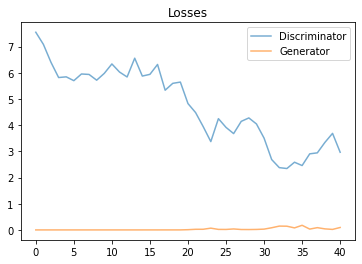

Epoch: 2, iteration: 82, d_loss: 1.392, g_loss: 0.477, duration: 140.551, minutes remaining: 2.0, remaining files in batch: 56 
Epoch 2/5 
D Loss: 2.25226 
G Loss: 0.36319


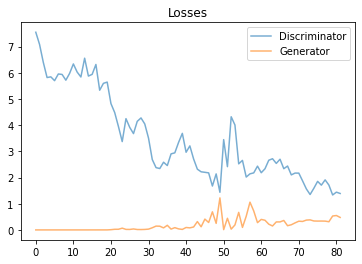

Epoch: 3, iteration: 123, d_loss: 1.16, g_loss: 0.45, duration: 142.234, minutes remaining: 2.1, remaining files in batch: 56 
Epoch 3/5 
D Loss: 1.32453 
G Loss: 0.39219


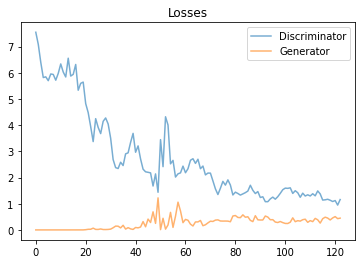

Epoch: 4, iteration: 164, d_loss: 0.876, g_loss: 0.532, duration: 132.132, minutes remaining: 1.9, remaining files in batch: 56 
Epoch 4/5 
D Loss: 1.00890 
G Loss: 0.50220


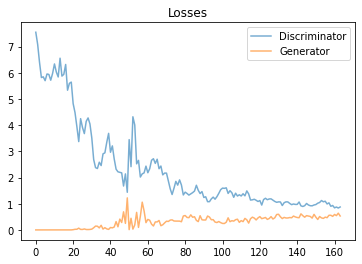

Epoch: 5, iteration: 205, d_loss: 0.934, g_loss: 0.627, duration: 141.488, minutes remaining: 2.1, remaining files in batch: 56 
Epoch 5/5 
D Loss: 0.91111 
G Loss: 0.57611


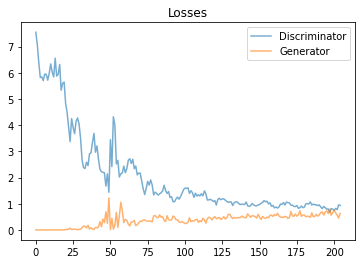

In [ ]:
# Training
with tf.Graph().as_default():
    train(data_shape=(DATASET_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3),
          epoch=EPOCH,
          checkpoint_path=None)